# Lab 2: Markov Models

------------

Explain what a Markov model is

In [ ]:
import markov
from midiutil import MIDIFile
import pandas as pd
from music21 import midi, converter
import numpy as np
from collections import Counter
from chord_dictionary import *
from time import time

## Text Generation

First we will use a Markov model to generate text. We will train the model on a single text file that includes text from *Alice in Wonderland* and *The Wizard of Oz*. You can take a look at the text below.

In [ ]:
with open("assets/alice_oz.txt", 'r') as f:
    text = f.readline()

text

We will train our Markov model one word at a time, so our input to the Markov model is a list of words:

In [ ]:
splitText = text.split()
splitText

In [ ]:
c = markov.Chain()
c.build(splitText)

The previous code cell trained our Markov chain on the text file. Now run the following cell to generate some text.

In [ ]:
np.random.seed(int(time()))
num_words = 39
' '.join(c.generate(nwords=num_words))

Observe how the generated text changes when the number of words to output is adjusted.

------

## Audio Generation

Now let's try our hand at audio generation. We will use a dataset of chorales written by [Johann Sebastian Bach](https://en.wikipedia.org/wiki/Johann_Sebastian_Bach) which are known for their stylistic similarities.

First, a bit of background.

A chorale is a piece of music, written for choir, in which the melody is usually from a hymn that would be well known to the audience and performers. Chorales contain a series of chords of four voices, which are (from highest to lowest): soprano, alto, tenor, and bass. The soprano (highest) voice sings the melody, while the lower three voices create the harmony of the piece. Each chord in the piece can be identified by its **root**, which is the pitch the chord is built on (like C, F#, or A-flat), and its **quality**, which describes both the relationship of the notes in the chord to each other, and the way the chord sounds. The four types of chord quality that are common in Bach chorales are major, minor, diminished, and augmented.

Listen to this Bach chorale, played on piano, to get a sense for the style. Pay particular attention to the harmonic material, as this is what we will try to replicate: [https://www.youtube.com/watch?v=L2cPibJzwbA&ab_channel=AndrewRemillard](https://www.youtube.com/watch?v=L2cPibJzwbA&ab_channel=AndrewRemillard)

If you want to listen to more chorales, and see accompanyig sheet music, see: [http://sporadic.stanford.edu/Chorales/](http://sporadic.stanford.edu/Chorales/)


### Data

Next take's take a look at the data. The dataset contains 60 chorales, and each chorale has roughly 100 chords in it.

The following code cell will display the first 100 rows of data. Each row corresponds to a single chord in the chorale.

The first column `choral_ID` tells us which chorale this is from. For the first 100 rows, all the data is from the same chorale: `000106b_`.

The next column `event_number` tells us the order of the chords in this chorale.

The next twelve rows, `pitch_1` ... `pitch_12` tell us which pitches are present in the chord. `pitch_1` is C, `pitch_2` is C#, and so on.

The `bass` column tells us which note is the bass note of the chord, which is the lowest note in the chord. This is important because in this style of music, the note of the chord that is in the bass can change the function of the chord in a progression. It is also common for the bassline to have a specific character and function compared to the other notes.

`meter` tells us the duration of that chord in number of beats.

Finally, `chord_label` tells us the root and quality of the chord. Most of the labels have the form `X_Y` where `X` is the root pitch of the chord (C, F, G#, Bb, etc.) and `Y` is the quality of the chord (`M` for major, `m` for minor, `d` for diminished, and `a` for augmented). For example, `C_M` is a C major chord, `D_m` is a D minor chord, `BbM` is a B-flat major chord.

In [ ]:
df = pd.read_csv('bach_choral_set_dataset.csv')
df.head(100)

In order to create a Markov chain that can generate Bach chorales, we need to think about how we can represent our data.

### MIDI

[Musical Instrument Digital Interface (MIDI)](https://en.wikipedia.org/wiki/MIDI) is a common protocol used to represent musical notes and events in digital format. MIDI is used in many processes: music production software, live performance, generating music from scores, and more. All MIDI parameters have a value from 0 to 127. A variety of musical parameters can be communicated using MIDI, the most common being pitch and velocity (volume). For example, the note C4 in MIDI is represented as the number 60. C#4 is 61, D4 is 62, and so on. This is convenient for performing computation on pitch. For example, to get the same pitch but higher one octave, simply add 12 to the MIDI pitch value. We will use MIDI to represent pitch in our Markov chain.

### Two Markov models

To generate a Bach chorale, we will train two different Markov models. The first will generate chords, and the second will generate the chord durations for our piece.

The first model will be trained on a `(chord, bass)` tuple, where `chord` is a list of MIDI pitches and `bass` is a single MIDI pitch that represents the pitch of the bass voice for that chord. The reason we separate the bass voice from the rest of the chord is because the bass line in Bach chorales determines the inversion of the chord, which has important functional consequences. We are able to do this because our dataset contains a row that specifies the bass pitch of each chord.

Our second model will determine how long each chord is held for. It is trained on the sequences of numbers gathered from the `meter` column.

In [ ]:
import markov_bach

midi_note_converter = {'pitch_1':60,
             'pitch_2':61,
             'pitch_3':62,
             'pitch_4':63,
             'pitch_5':64,
             'pitch_6':65,
             'pitch_7':66,
             'pitch_8':67,
             'pitch_9':68,
             'pitch_10':69,
             'pitch_11':70,
             'pitch_12':71}


bass_converter = {'C': 48,
                  'C#': 49,
                  'Db': 49,
                  'D': 50,
                  'Eb': 51,
                  'D#': 51,
                  'E': 52,
                  'F': 53,
                  'F#': 54,
                  'G': 55,
                  'G#': 56,
                  'Ab': 56,
                  'A': 57,
                  'Bb': 58,
                  'A#': 58,
                  'B': 59
}

def string2int(chord):
    return [int(i) for i in chord.strip('[').strip(']').split(', ')]

def chord2midi(chord_bass_tuple):
    """
    Convert (chord name, bass note) tuple to a (chord as midi list, bass as midi note) tuple
    """
    chord, bass = chord_bass_tuple
    return chords[chord][bass], bass_converter[bass]

df = pd.read_csv('assets/encoded.csv')
note_columns = df.columns[2:14]

# the 'chords' dict maps a chord (F_M) to a dictionary, where the keys are bass notes. Each bass note maps
# to a single list of MIDI pitches that represent the notes in the chord
chords = {}
for i, row in df.iterrows():
    chord = row['chord_label']
    bass = row['bass']
    if chord not in chords:
        chords[chord] = {}
    if bass not in chords[chord].keys():
        notes = []
        for col in note_columns:
            if row[col] == 1:
                note = midi_note_converter[col]
                notes.append(note)
        chords[chord][bass] = str(notes)

Run the following cell to generate a Bach chorale!

We set the starting chord to be C major with a C in the bass. After listening, you can change the first two lines to change the starting chord and bass note.

For example, try changing the line `start_chord = 'C_M` to `start_chord = 'D_m'` and change the second line `start_bass = 'C'` to `start_bass = 'F'`. Play around with different combinations and see what you get. Is there a combination that seem most convincing? Can you find a combination that makes the worst sounding chorale?

In [ ]:
start_chord = 'D_M'
start_bass = 'D'

chord_model = markov_bach.Chain(NONWORD=(start_chord, start_bass), NPREF=4)
meter_model = markov_bach.Chain(NONWORD=3, NPREF=2)

# train on each chorales
for chorale in df['choral_ID'].unique():
    d = df[df['choral_ID'] == chorale]  # select only the rows from a single chorale
    chord_stream = [(i['chord_label'], i['bass']) for k, i in d.iterrows()]  # sequential list of all chord/bass tuples
    chord_model.build(chord_stream)
    meter_stream = np.array(d['meter'], dtype='str')
    meter_model.build(meter_stream)

# generate chords and durations
generated_chords = chord_model.generate(first=(start_chord, start_bass))
generated_meter = meter_model.generate(first=3)

# convert chord names to midi note lists
# generated_chords[i] is a tuple: (chord as midi list, midi bass note)
generated_chords_midi = [chord2midi(x) for x in generated_chords]


# create MIDI
track = 0
channel = 0
time = 0
duration = 1
tempo = 60
volume = 100

MIDI = MIDIFile(2)
# MIDI.addTempo(track, time, tempo)

t = 0

start_c = string2int(chords[start_chord][start_bass])
start_b = bass_converter[start_bass]
duration = 4
for c in start_c:
    MIDI.addNote(track, channel, c, t, duration, volume)
MIDI.addNote(track, channel, start_b, t, duration, volume)
t += duration

for i in range(len(generated_chords_midi)):
    chord, bass = generated_chords_midi[i]
    chord = string2int(chord)
    duration = int(generated_meter[i])

    for note in chord:
        MIDI.addNote(track, channel, note, t, duration, volume)

    MIDI.addNote(track, channel, bass, t, duration, volume - 10)

    t += duration


with open("generated_all_midi.mid", 'wb') as output_file:
    MIDI.writeFile(output_file)

mf = midi.MidiFile()
mf.open('generated_all_midi.mid')
mf.read()
mf.close()
s = midi.translate.midiFileToStream(mf)

print((start_c, start_b), generated_chords)
score = converter.parse('generated_all_midi.mid')
score.show()
s.show('midi')

What do you think of our Markov generated Bach chorales? Are they convincing?

It certanly is making music, but is it music in the style of Bach? Some of the qualities we expect are there, like the common V-I progression that often appears in the generated sequences. However, it isn't good enough to create a convincing recreation of Bach.

What is missing? First, the harmonic progressions we expect to hear. Rhythms beyond quarter notes. Form. Repeated material.

Markov chains have some promise when it comes to generating music and sound with data, but now we will take a look at a process that is much more convincing: neural networks. Check out the Bach Google doodle, which uses multiple neural networks to create pieces in Bach's style: [https://www.google.com/doodles/celebrating-johann-sebastian-bach](https://www.google.com/doodles/celebrating-johann-sebastian-bach)

([62, 66, 69], 50) [('E_m', 'G'), ('E_m', 'G'), ('A_M', 'A'), ('A_M', 'A'), ('A_M', 'A'), ('B_m', 'B'), ('B_m', 'B'), ('A_M', 'C#'), ('A_M', 'D'), ('E_M', 'E'), ('E_M', 'D'), ('A_M', 'C#'), ('A_M', 'A'), ('A_M', 'A'), ('E_M', 'E'), ('E_M', 'E'), ('F#m', 'F#'), ('F#m', 'E'), ('B_M', 'D#'), ('B_M', 'D#')]


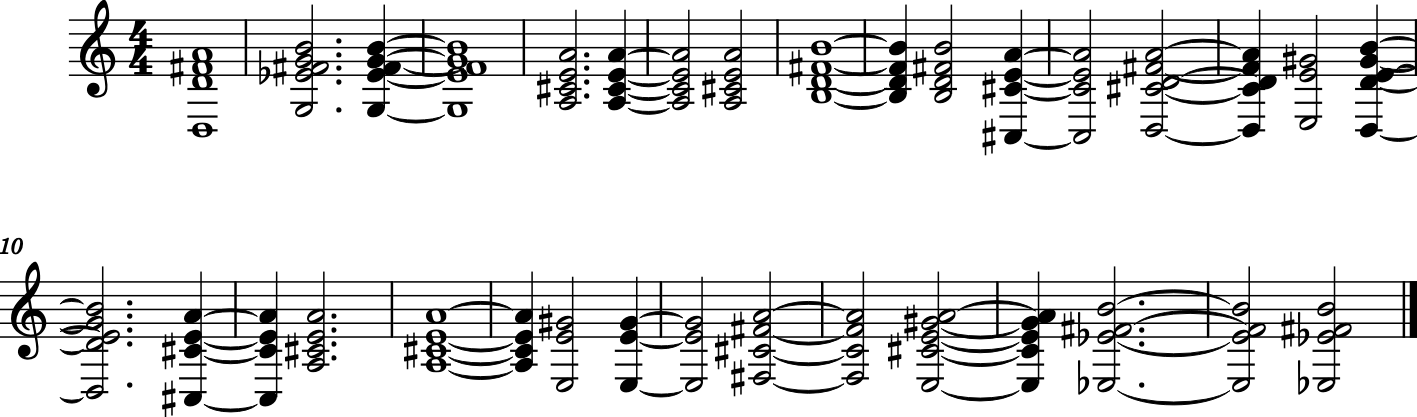

In [1]:
from midiutil import MIDIFile
import pandas as pd
from music21 import midi, converter

import collections
import numpy as np

import markov_bach

midi_note_converter = {'pitch_1':60,
             'pitch_2':61,
             'pitch_3':62,
             'pitch_4':63,
             'pitch_5':64,
             'pitch_6':65,
             'pitch_7':66,
             'pitch_8':67,
             'pitch_9':68,
             'pitch_10':69,
             'pitch_11':70,
             'pitch_12':71}


def string2int(chord):
    return [int(i) for i in chord.strip('[').strip(']').split(', ')]


df = pd.read_csv('assets/encoded.csv')
note_columns = df.columns[2:14]

# the 'chords' dict maps a chord (F_M) to a dictionary, where the keys are bass notes. Each bass note maps
# to a single list of MIDI pitches that represent the notes in the chord
chords = {}
for i, row in df.iterrows():
    chord = row['chord_label']
    bass = row['bass']
    if chord not in chords:
        chords[chord] = {}
    if bass not in chords[chord].keys():
        notes = []
        for col in note_columns:
            if row[col] == 1:
                note = midi_note_converter[col]
                notes.append(note)
        chords[chord][bass] = str(notes)


bass_converter = {'C': 48,
                  'C#': 49,
                  'Db': 49,
                  'D': 50,
                  'Eb': 51,
                  'D#': 51,
                  'E': 52,
                  'F': 53,
                  'F#': 54,
                  'G': 55,
                  'G#': 56,
                  'Ab': 56,
                  'A': 57,
                  'Bb': 58,
                  'A#': 58,
                  'B': 59
}

start_chord = 'D_M'
start_bass = 'D'

chord_model = markov_bach.Chain(NONWORD=(start_chord, start_bass), NPREF=4)
meter_model = markov_bach.Chain(NONWORD=3, NPREF=2)
#bass = Chain(NONWORD='F', NPREF=4)

# create markov chains from all chorales
for chorale in df['choral_ID'].unique():
    d = df[df['choral_ID'] == chorale]  # select only the rows from a single chorale
    chord_stream = [(i['chord_label'], i['bass']) for k, i in d.iterrows()]  # sequential list of all chord/bass tuples
    chord_model.build(chord_stream)
    meter_stream = np.array(d['meter'], dtype='str')
    meter_model.build(meter_stream)

# generate chords and durations
generated_chords = chord_model.generate(first=(start_chord, start_bass))
generated_meter = meter_model.generate(first=3)

def chord2midi(chord_bass_tuple):
    """
    Convert (chord name, bass note) tuple to a (chord as midi list, bass as midi note) tuple
    """
    chord, bass = chord_bass_tuple
    return chords[chord][bass], bass_converter[bass]

# convert chord names to midi note lists
# generated_chords[i] is a tuple: (chord as midi list, midi bass note)
generated_chords_midi = [chord2midi(x) for x in generated_chords]

# create MIDI
track = 0
channel = 0
time = 0
duration = 1
tempo = 60
volume = 100

MIDI = MIDIFile(2)
# MIDI.addTempo(track, time, tempo)

t = 0

start_c = string2int(chords[start_chord][start_bass])
start_b = bass_converter[start_bass]
duration = 4
for c in start_c:
    MIDI.addNote(track, channel, c, t, duration, volume)
MIDI.addNote(track, channel, start_b, t, duration, volume)
t += duration

for i in range(len(generated_chords_midi)):
    chord, bass = generated_chords_midi[i]
    chord = string2int(chord)
    duration = int(generated_meter[i])

    for note in chord:
        MIDI.addNote(track, channel, note, t, duration, volume)

    MIDI.addNote(track, channel, bass, t, duration, volume - 10)

    t += duration


with open("generated_all_midi.mid", 'wb') as output_file:
    MIDI.writeFile(output_file)

mf = midi.MidiFile()
mf.open('generated_all_midi.mid')
mf.read()
mf.close()
s = midi.translate.midiFileToStream(mf)

print((start_c, start_b), generated_chords)
score = converter.parse('generated_all_midi.mid')
score.show()
s.show('midi')